# Probabilistic Machine Learning
<div style="text-align: right"> University of Tübingen, Summer Term 2023  &copy; 2023 P. Hennig </div>


Theory Question: In the lecture, we encountered the Beta distribution
$$
p(x \mid a, b)=\mathcal{B}(x ; a, b):=\frac{1}{B(a, b)} x^{a-1}(1-x)^{b-1}
$$
where the normalization constant $B(a, b)=\Gamma(a) \Gamma(b) / \Gamma(a+b)$ is the Beta function, using the (Euler) Gamma function. The Beta is conjugate to the binomial distribution
$$
p(n, m \mid x)=\left(\begin{array}{c}
n+m \\
n
\end{array}\right) x^n(1-x)^m
$$

That is, the posterior on $x$ arising from the Beta prior and the binomial likelihood is $\mathcal{B}(x ; a+n, b+m)$. In this question, we will study the generalization to the multinomial case: Consider a data set $C=\left[c_1, c_2, \ldots, c_N\right]$ of discrete labels $c_i \in\{1,2,3, \ldots, K\}$. It is convenient to use the notation $n_k=\left|\left\{c_i \in C \mid c_i=k\right\}\right|$ for the number of labels observed in class $k$. We assume these data are drawn iid. from the multinomial distribution
$$
p(C \mid \boldsymbol{x})=\prod_{i=1}^N x_{c_i}=\frac{N !}{\prod_{\ell=1}^K n_{\ell} !} \prod_{k=1}^K x_k^{n_k} .




(a) Show that the Dirichlet distribution (with parameter vector $\boldsymbol{\alpha} \in \mathbb{R}_{+}^K$ )
$$
\mathcal{D}(\boldsymbol{x} \mid \boldsymbol{\alpha})=\frac{\Gamma\left(\sum_k \alpha_k\right)}{\prod_k \Gamma\left(\alpha_k\right)} \prod_k x_k^{\alpha_k-1}
$$
is the conjugate prior for the multinomial (1). What is the associated posterior?

(b) Show that the Dirichlet distribution has the aggregation property: If $p(\boldsymbol{x})=\mathcal{D}(\boldsymbol{x} ; \boldsymbol{\alpha})$, then
$$
\begin{aligned}
p\left(\left[x_1, x_2, \ldots, x_i+x_j, \ldots x_{j-1}\right.\right. & \left.\left., x_{j+1}, \ldots, x_K\right]\right) \\
& =\mathcal{D}\left(\cdot ;\left[\alpha_1, \alpha_2, \ldots, \alpha_i+\alpha_j, \ldots, \alpha_{j-1}, \alpha_{j+1}, \ldots, \alpha_K\right]\right)
\end{aligned}
$$

(c) Show that the logarithm of the likelihood (1), as a function of $\boldsymbol{x}$, is the crossentropy $\operatorname{loss}^1$ for $\boldsymbol{x}$. What is the maximum-likelihood estimate for $\boldsymbol{x}$ ? How does it relate to the maximum ${ }^2$ of the posterior?

(d) Consider the following situation: You are on an e-commerce marketplace, which uses ratings on the common "five stars" scale. You have the choice between two vendors there. The first vendor has only three ratings so far, but they are all five-star ratings (i.e. their rating "vector" is $\left.C_1=[0,0,0,0,3]\right)$. The second vendor has many more ratings, their rating vector is $C_2=[1,0,12,43,354]$. Let's assume (questionably) that these ratings are drawn iid. from two multinomial distributions with parameter $\boldsymbol{x}_1$ and $\boldsymbol{x}_2$, one for each vendor. Use the results above to answer the following questions:
i. What are the maximum likelihood estimates for $\boldsymbol{x}_1$ and $\boldsymbol{x}_2$ ?
ii. Under a uniform Dirichlet prior $(\boldsymbol{\alpha}=[1,1,1,1,1])$ what is the probability for your rating to be five stars? What is the probability for your rating to be four or five stars? (Assume you pick either one of the vendors, and your future rating will be distributed just as the existing ones. To answer this question, you need to compute integrals of the form $\int x_i \mathcal{D}(\boldsymbol{x} \mid \boldsymbol{\alpha}) d \boldsymbol{x}$. Think about how to do this.)

## Laplace Approximations


In [1]:
from io import StringIO

import pandas as pd
import requests

import jax
from jax import numpy as jnp
from jax.scipy import optimize

from matplotlib import pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import numpy as np

from tueplots import bundles
from tueplots.constants.color import rgb


plt.rcParams.update(bundles.beamer_moml())
plt.rcParams.update({"figure.dpi": 200})


# Exercise 2.2 (Coding Exercise)


In this exercise we are going to practice the Laplace approximation, as well as `jax`. You can use the functionality from `jax` whereever you want to. Your tasks are the following:

**Task 1.** Implement the Beta distribution:

$$ p_z(z) = Beta(z;a,b)$$

You can do it yourself, or use `jax.scipy.stats.beta.pdf`.


In [2]:
def p_z(z, a, b):
    """Beta distribution p_z(z).
    
    Args:
      z: Float, Argument of the beta distribution.
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.
      
    Returns:
      Value of the probability density function at z.
    """
    # TODO
    return jax.scipy.stats.beta.pdf(z, a, b)

**Task 2.** What is the distribution $p_x(x)$ of $x$ if 

$$ z = logisitc(x) \hspace{1cm} \text{with } \hspace{0.5cm} logistic(x) = 1/(1+exp(-x)?$$

Implement it using the transformation rules from the lecture. `jax.jacrev` might be helpful for calculating Jacobians.

Theorem (Transformation Law, general)
Let $X=\left(X_1, \ldots, X_d\right)$ have a joint density $p_X$. Let $g: \mathbb{R}^d \rightarrow \mathbb{R}^d$ be continously differentiable and injective, with non-vanishing Jacobian $J_g$. Then $X=g(Z)$ has density
$$
p_X(x)= \begin{cases}p_Z\left(g^{-1}(x)\right) \cdot\left|J_{g^{-1}}(x)\right| & \text { if } x \text { is in the range of } g \\ 0 & \text { otherwise. }\end{cases}
$$

In [3]:
def p_x(x, a, b):
    """Probability density function for x with z=logistic(x). 
    
    Args:
      z: Float, Argument of p_x.
      a: Float, Parameter of the beta distribution of z.
      b: Float, Parameter of the beta distribution of z.
      
    Returns:
      Value of the probability density function p_x(x) at x.
    """
    # TODO
    logistic_x = jax.scipy.special.expit(x)
    p_Z = p_z(logistic_x, a, b)
    p_X = p_Z * jax.scipy.special.expit(x) * (1 - jax.scipy.special.expit(x))
    return p_X

**Task 3.** Compute the Laplace approximations for both,  $p_z(z)$ and $p_x(x)$.

In [12]:
def laplace_z(a, b):
    """Laplace approximation for the beta distribution.
    
    Args:
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.
      
    Returns:
      A function with the same argument as the beta distribution. 
    """
    # TODO
    #Laplace approximation for the beta distribution
    x_hat = (a - 1) / (a + b - 2)
    hessian = (a + b - 2) ** 2 * (1/(a - 1) + 1/(b - 1))
    p_Z = lambda z: jax.scipy.stats.norm.pdf(z, x_hat, 1 / jnp.sqrt(hessian))
    return p_Z

def laplace_x(a, b):
    """Laplace approximation for p_x with z=logistic(x). 
    
    Args:
      a: Float, Parameter of the beta distribution.
      b: Float, Parameter of the beta distribution.
      
    Returns:
      A function with the same argument as p_x. 
    """
    # TODO
    p_Z = laplace_z(a, b)
    p_X = lambda x: p_Z(jax.scipy.special.expit(x)) * jax.scipy.special.expit(x) * (1 - jax.scipy.special.expit(x))
    return p_X

**Task 4.** Make a plot for $p_z(z)$ and it's Laplace approximation for the parameter combinations $a=2, b=3$ and $a=5, b=5$. Are there parameter combinations, where the Laplace approximation is undefined? Make the same plot for $x$, too.

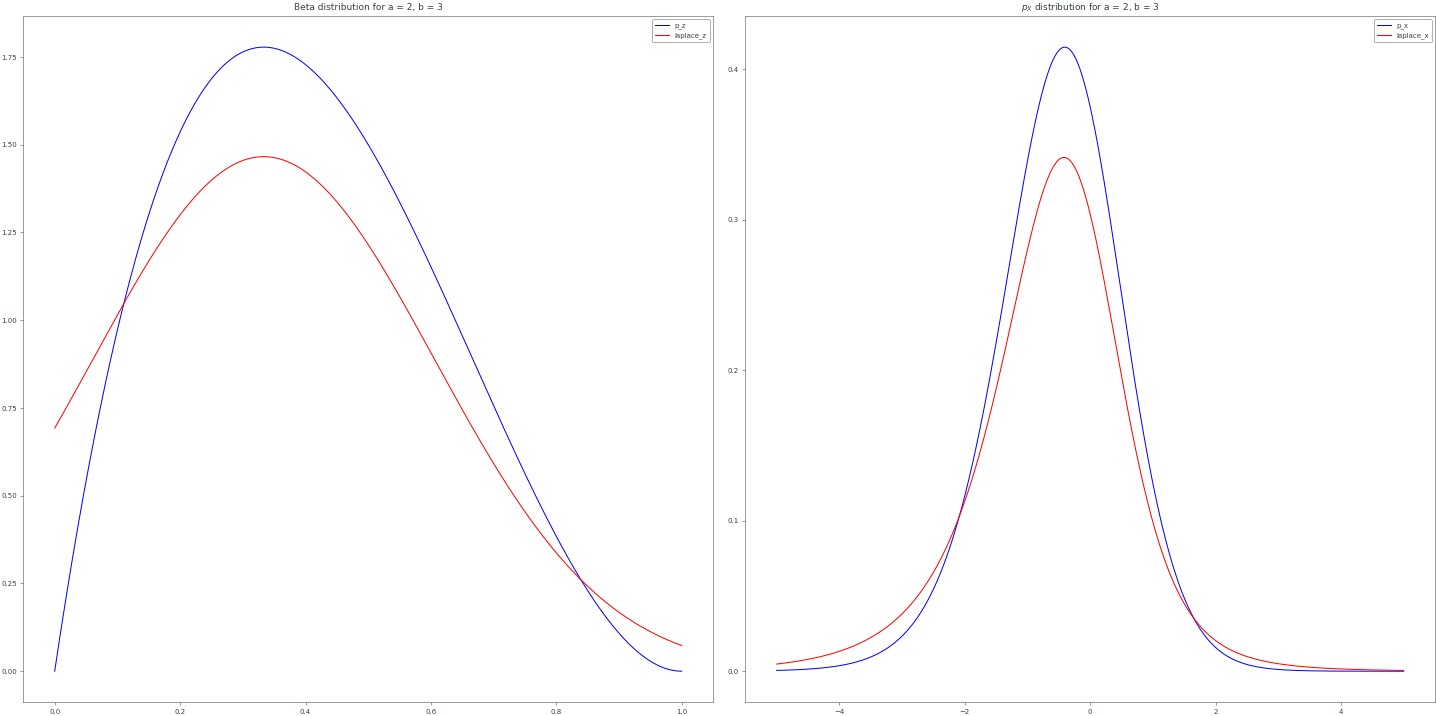

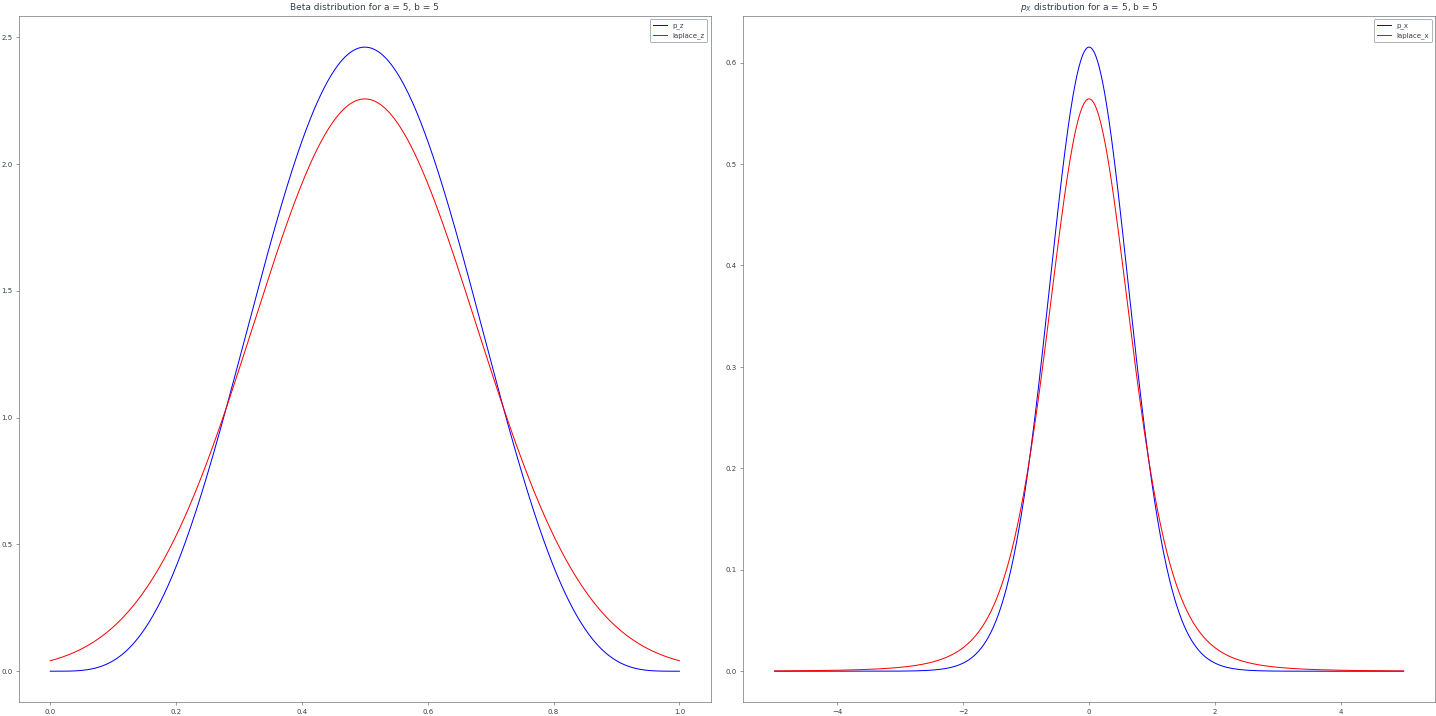

In [13]:
# TODO: Plot 
z = np.linspace(0, 1, 1000)
x = np.linspace(-5, 5, 1000)
a = 2
b = 3
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(z, p_z(z, a, b), label="p_z", color="blue")
ax1.plot(z, laplace_z(a, b)(z), label="laplace_z", color="red") 
ax1.set_title("Beta distribution for a = 2, b = 3")
ax1.legend()

ax2.plot(x, p_x(x, a, b), label="p_x", color="blue")
ax2.plot(x, laplace_x(a, b)(x), label="laplace_x", color="red")
ax2.set_title("$p_X$ distribution for a = 2, b = 3")
ax2.legend()

# TODO: Plot 
a = 5
b = 5
z = np.linspace(0, 1, 1000)
x = np.linspace(-5, 5, 1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.plot(z, p_z(z, a, b), label="p_z", color="blue")
ax1.plot(z, laplace_z(a, b)(z), label="laplace_z", color="red")
ax1.set_title("Beta distribution for a = 5, b = 5")

ax1.legend()

ax2.plot(x, p_x(x, a, b), label="p_x", color="blue")
ax2.plot(x, laplace_x(a, b)(x), label="laplace_x", color="red")
ax2.set_title("$p_X$ distribution for a = 5, b = 5")
ax2.legend()

**Task 5.** Implement the Dirichlet distribution

$$ p_y(y) = Dirichlet(y; \alpha)$$

(alternative:`jax.scipy.stats.dirichlet.pdf`) and it's Laplace approximation. 

In [6]:
def p_y(y, alpha):
    """Dirichlet distribution p_y(y).
    
    Args:
      y: ArrayLike, Argument of the Dirichlet distribution.
      alpha: ArrayLike, Parameter of the Dirichlet distribution.
      
    Returns:
      Value of the probability density function at z.
    """
    # TODO
    return jax.scipy.stats.dirichlet.pdf(y, alpha)

def laplace_y(alpha):
    """Laplace approximation for the Dirichlet distribution p_y. 
    
    Args:
      alpha: ArrayLike, Parameter of the Dirichlet distribution.
      
    Returns:
      A function with the same argument as p_y. 
    """
    # TODO
    return lambda y: jax.scipy.stats.multivariate_normal.pdf(y, mean=alpha / jnp.sum(alpha), cov=jnp.diag(alpha / jnp.sum(alpha)**2))

**Task 6.**
For $\alpha = (2, 10, 2)$ and $\alpha = (3, 2, 5)$, plot $p_y(y)$ and it's Laplace approximation next to each other. The function `simplex_contour_plot` implemented below can help with contour plots over the simplex. You can adapt it in any way you like.

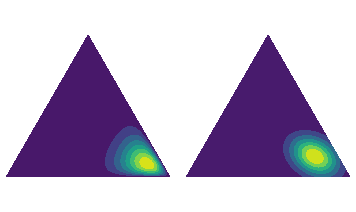

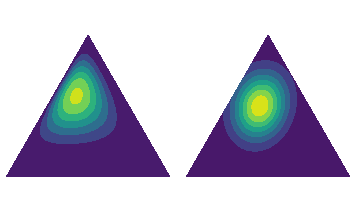

In [7]:
def simplex_contour_plot(fun1, fun2):
    """Make contour plots for two functions, each defined over the probability simplex
       represented by a triangualar surface.
    
    Args:
      fun1: function, defined over the probability simplex in three dimensions.
      fun2: function, defined over the probability simplex in three dimensions.
      
    Based on: https://blog.bogatron.net/blog/2014/02/02/visualizing-dirichlet-distributions/
    """
    
    # Define the triangle
    corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
    area = 0.5 * 1 * 0.75**0.5
    triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=8)
    
    # For each corner of the triangle, the pair of other corners
    pairs = [corners[np.roll(range(3), -i)[1:]] for i in range(3)]
    
    # The area of the triangle formed by point xy and another pair or points
    tri_area = lambda xy, pair: 0.5 * np.linalg.norm(np.cross(*(pair - xy)))
    
    # Convert cartesian to barycentric coordinates  
    def xy2bc(xy, tol=1e-6):
        coords = np.array([tri_area(xy, p) for p in pairs]) / area
        return np.clip(coords, tol, 1.0 - tol)
    
    values1 = [fun1(xy2bc(xy)).item() for xy in zip(trimesh.x, trimesh.y)]
    values2 = [fun2(xy2bc(xy)).item() for xy in zip(trimesh.x, trimesh.y)]
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
    axes[0].tricontourf(trimesh, values1)
    axes[1].tricontourf(trimesh, values2)
    axes[0].axis('equal')
    axes[1].axis('equal')
    axes[0].axis('off')
    axes[1].axis('off')
    plt.show()


def func_p_y(alpha):
    return lambda y: p_y(y, alpha)

# TODO: Plot
alpha = np.array([2, 10, 2])
simplex_contour_plot(func_p_y(alpha=alpha), laplace_y(alpha))

alpha = np.array([3, 2, 5])
simplex_contour_plot(func_p_y(alpha=alpha), laplace_y(alpha))

### How to submit your work:

Export your answer into a pdf (for example using jupyter's `Save and Export Notebook as` feature in the `File` menu). Make sure to include all outputs, in particular plots. Also include your answer to the theory question, either by adding it as LaTeX code directly in the notebook, or by adding it as an extra page (e.g. a scan) to the pdf. Submit the exercise on Ilias, in the associated folder. **Do not forget to add your name(s) and matricel number(s) above!)**